Copyright **`(c)`** 2023 Angelo Iannielli s317887 `<angelo.iannielli@studenti.polito.it>`  
[`https://github.com/AngeloIannielli/polito-computational-intelligence-23`]  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [9]:
from random import choices
from random import random, randint, sample
from collections import namedtuple
from copy import deepcopy, copy 
from typing import List
import matplotlib.pyplot as plt

import lab9_lib

In [10]:
# GLOBAL VARIABLES INITIALIZATION

LOCI = 1000
population = []

THRESHOLDS = 3
DIM_FIRST_POP = 100

GENERATIONS = 10000
gen = 1

problem = lab9_lib.make_problem(1)

In [11]:
class Individual:
    def __init__(self):
        self.genome = []
        self.fitness = 0

    def generate_randomly(self):
        self.genome = choices([0, 1], k=LOCI)
        self.fitness = problem(self.genome)

    def generate_by_recombination(self, mut_rate, parents):
        
        # Define the dimension of the slices in the xover
        dim_slice = randint(1, LOCI // len(parents))

        for slice in range(LOCI // dim_slice):
            selected_parent = choices(parents, weights=[p.fitness for p in parents], k=1)
            genes = selected_parent[0].genome[slice * dim_slice : slice * dim_slice + dim_slice]
            self.genome.extend(genes)

        # Fill the genes out of the last slice
        selected_parent = choices(parents, weights=[p.fitness for p in parents], k=1)
        genes = selected_parent[0].genome[LOCI // dim_slice * dim_slice : LOCI]
        self.genome.extend(genes)

        for index in range(len(self.genome)):
            if random() < mut_rate :
                self.genome[index] = 1 if self.genome[index] == 0 else 0

    def estimate_fitness(self):
        self.fitness = problem(self.genome)

    def __str__(self):
        return f"{self.fitness:.2%} : {''.join(str(g) for g in self.genome)}"



In [12]:
class Island:
    def __init__(self, min_fitness, max_fitness, population, num_parents, mut_rate, dim_population, dim_tournament, level):
        self.min_fitness = min_fitness
        self.max_fitness = max_fitness
        self.population = population
        self.num_parents = num_parents
        self.mut_rate = mut_rate
        self.dim_population = dim_population
        self.dim_tournament = dim_tournament
        self.level = level

    def parents_selection(self):
        # sorted_population = sorted(self.population, key=lambda ind: ind.fitness, reverse=True)
        # return sorted_population[:self.dim_population]

        population_copy = copy(self.population)
        parents = []

        for _ in range(len(self.population)//self.dim_tournament):
            tournament = sample(population_copy, k= self.dim_tournament)
            tournament = sorted(tournament, key=lambda ind: ind.fitness, reverse=True)

            parents.append(tournament.pop(0))
            for loser in tournament:
                population_copy.remove(loser)

        return parents        
    
    def survival_selection(self):
        sorted_population = sorted(self.population, key=lambda ind: ind.fitness, reverse=True)

        travellers = namedtuple('travellers', ['weak', 'strong'])
        weak_population = []
        strong_population = []
        new_sorted_population = []
        

        for ind in sorted_population:

            # If the individual has a low fitness it is demote to a lower island
            if ind.fitness < self.min_fitness:
                weak_population.append(ind)

            # If the individual has a high fitness it is promote to an higher island
            elif ind.fitness > self.max_fitness:
                strong_population.append(ind)

            else:
                new_sorted_population.append(ind)
        
        return travellers(weak_population, strong_population)
    
    def shrink_population(self):
        sorted_population = sorted(self.population, key=lambda ind: ind.fitness, reverse=True)
        self.population = sorted_population[:self.dim_population]

    def get_top_solution(self) -> Individual :
        if len(self.population) > 0:
            return self.population[0]
        else: 
            return None
    
    def __str__(self):
        return f"Island {self.min_fitness:.2%}-{self.max_fitness:.2%} > POPULATION SIZE: {len(self.population)}"

In [13]:
archipelago: List[Island] = []
solution = Individual()

In [14]:
archipelago: List[Island] = []
THRESHOLDS = 3
DIM_FIRST_POP = 80

solution = Individual()
best_solutions_fitness = []

for level in range(THRESHOLDS):
    archipelago.append(Island(min_fitness= 1 / THRESHOLDS * level, max_fitness= 1 / THRESHOLDS * ( level + 1), population= [], num_parents= THRESHOLDS - level + 1, mut_rate= 1 / (10 ** (level + 1)), dim_population= DIM_FIRST_POP // ( level + 1 ), dim_tournament= THRESHOLDS + 2, level= level))

# FIRST GENERATION
for _ in range(DIM_FIRST_POP):
    ind = Individual()
    ind.generate_randomly()
    archipelago[0].population.append(ind)

weak, strong = archipelago[0].survival_selection()

print("Weak dim: ", len(weak), " Strong dim: ", len(strong))

# Put the weak individuals in the correct island
for ind in weak:
    for island in archipelago:
        if ind.fitness > island.min_fitness and ind.fitness < island.max_fitness:
            island.population.append(ind)

# Bring the strong individual high
for ind in strong:
    for island in archipelago:
        if ind.fitness > island.min_fitness and ind.fitness < island.max_fitness:
            island.population.append(ind)

for island in archipelago:
    # Shrink the population to dim_population elements
    island.shrink_population()
    print(island)
    for ind in island.population:
        print(ind)

# Save the top solution 
for island in reversed(archipelago):
    current_top_solution = island.get_top_solution()
    if current_top_solution:
        print("Top solution:", current_top_solution)
        solution = current_top_solution
        break  

best_solutions_fitness.append(solution.fitness)
print(problem.calls)



Weak dim:  0  Strong dim:  80
Island 0.00%-33.33% > POPULATION SIZE: 80
54.60% : 1100001111010111111011110110110100001111100001101101010110111010111101011011101000011101001010001001011101111011001100100011001000110010010011110011100001110001000011000011101100110110110011111111011111100001001110001101101011110001101100101001011111110110011111110000001001101111001110111101001101111110010011001000010101000110111101110101001001011110110101011110101110101001010011101111000000101101110001011010010000100110101111111110001001011100010010111111001100001010001011101010000101110010001011001111001110011100100110111101000101101010111110000010100111100001110101111100101010100110101011111110010010011010011111111011111100000000011110011101100011111100010111101110011110100111010010101001100000100101100111111001110100111100100011001110111000010000111011110001101001111110100000101100000010010100000111010100010110011010110001011101001001111111000100110111111000111011110110001100000010010111110011011110010

In [15]:
GENERATIONS = 10000
gen = 1

# Iterate until a perfect solution is found or the number of generations is reached
while solution.fitness < 1.0 and gen < GENERATIONS:
    
    print("GENERATION", gen)

    # For each island, select a group of parents and generate the offsprings
    for island in archipelago:
        selected_parents = island.parents_selection()

        # The number of new offsprings is enough to fill the expected space of the island
        for _ in range(island.dim_population):

            # Every island needs a specific number of parents to create a new individual
            if len(selected_parents) > island.num_parents:
                parents = sample(selected_parents, k= island.num_parents)

                child = Individual()
                    
                child.generate_by_recombination(island.mut_rate, parents)

                child.estimate_fitness()

                island.population.append(child)

    # For each island, there is a survival selection. The final number of individuals must be <= dim_population 
    for island in archipelago:

        # Every selection updates the population inside the island and returns two lists of individuals that are promoted/demoted
        weak, strong = island.survival_selection()

        print("Island LVL", island.level, ">", "promoted:", len(strong), "demoted:", len(weak))

        for ind in weak:
            for index in range(0, island.level):
                island = archipelago[index]
                if ind.fitness > island.min_fitness and ind.fitness < island.max_fitness:
                    island.population.append(ind)

        for ind in strong:
            for index in range(island.level + 1, len(archipelago)):
                island = archipelago[index]
                if ind.fitness > island.min_fitness and ind.fitness < island.max_fitness:
                    island.population.append(ind)

    for island in archipelago:
            # Shrink the population to dim_population elements
            island.shrink_population()
            
            print(island)

    # Check the top solution 
    current_top_solution = None

    # Start by searching from the highest level
    for island in reversed(archipelago):
        current_top_solution = island.get_top_solution()
        
        # When a solution is found, it must be the better (because it is in the first position of the top level)
        if current_top_solution:
            print("Current top sol:", current_top_solution)

            # Check if the solution is better than the latest one
            if current_top_solution.fitness > solution.fitness :
                gain = (current_top_solution.fitness - solution.fitness)
                print(f"Found a better solution (+{gain:.2%}): {current_top_solution}")
                solution = current_top_solution
            break    

    best_solutions_fitness.append(solution.fitness)
    print("Fitness called", problem.calls, "times")
    print("")            
                    
    gen += 1

GENERATION 1
Island LVL 0 > promoted: 160 demoted: 0
Island LVL 1 > promoted: 0 demoted: 0
Island LVL 2 > promoted: 0 demoted: 0
Island 0.00%-33.33% > POPULATION SIZE: 80
Island 33.33%-66.67% > POPULATION SIZE: 40
Island 66.67%-100.00% > POPULATION SIZE: 0
Current top sol: 55.80% : 010110111001001011111000011000111101110100011110001101010111010110101110111010100010111110100111000001010111001111110011000110001001011110011000001001110110000011110111101111010001111011110100011101111011010010101111011111011011011001111111110100010000010001100010100010111101110110101011001110010010110111000010111100100100011110100110110011010101111011101111100001100001100100110011101011001111101111100110110001000101111001000101001000101111110011001111001110111010001011110111100110100101110100110110111110010110010100101110101111111101000010101001100111111010111100000100001011111111011100111010110110110000001100100111101011111001100110011000010011101111101001111010011100100101110100011100001000011110111111101

Island LVL 0 > promoted: 160 demoted: 0
Island LVL 1 > promoted: 0 demoted: 0
Island LVL 2 > promoted: 0 demoted: 0
Island 0.00%-33.33% > POPULATION SIZE: 80
Island 33.33%-66.67% > POPULATION SIZE: 40
Island 66.67%-100.00% > POPULATION SIZE: 0
Current top sol: 57.90% : 0101101111000010010110000110001111100110000111100011010101110101101011111110101000101111101001110000010101110010100100100111011100010111100101010000111101100000101101111011110100011110111101000101011110110100100011111100110111110111001011101001101111011000000011001110011101110111101100010111011011011001000000111111001001001110111101010010010000111110111111111100100101110011111101111111001000110010110011101100010011011110010001011111110001010010001100011011011010111011111100111110010110001001110000001011110101110101011110010011100010111101111100101011110111001100111101111101011001111111100101101110101110111000110110110101011111010000101110110011010011111111111101101111001110101000010011110100100100111001001110101111111100

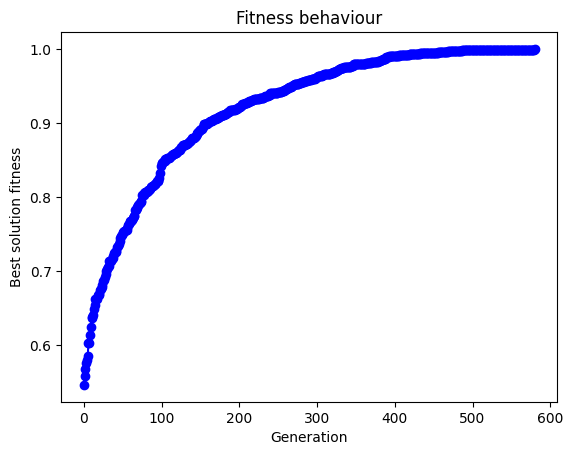

In [16]:
# Crea il grafico
plt.plot(list(range(gen)), best_solutions_fitness, marker='o', linestyle='-', color='b')

# Aggiungi etichette e titoli
plt.xlabel('Generation')
plt.ylabel('Best solution fitness')
plt.title('Fitness behaviour')

# Visualizza il grafico
plt.show()